In [1]:
library(dplyr)
library(broom)
library(MASS)
library(ggplot2)
library(purrr)
library(tidyr)
library(knitr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    combine, src, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [2]:
# set number of observations
n <- 10000

# make this reproducible
set.seed(7)

# simulate some data!
bandit_data <- data_frame(
  clicked_sports = sample(c(0,1), n, prob = c(0.6, 0.4), replace = T),
  clicked_politics = sample(c(0,1), n, prob = c(0.7, 0.3), replace = T),
  arm = sample(c(1:3), n, replace =  T),
  sports_coef = case_when(arm == 1 ~ .5,
                          arm == 2 ~ .1,
                          arm == 3 ~ .1),
  politics_coef = case_when(arm == 1 ~ .1,
                            arm == 2 ~ .1,
                            arm == 3 ~ .4),
  arm_baseline = case_when(arm == 1 ~ .1,
                           arm == 2 ~ .2,
                           arm == 3 ~ .1),
  rand_draw = runif(n)
) %>%
  mutate(click_factor = arm_baseline + sports_coef * clicked_sports + politics_coef * clicked_politics) %>%
  mutate(click = ifelse(click_factor >= rand_draw, 1, 0))

In [3]:
bandit_data %>%
  group_by(arm, clicked_sports, clicked_politics) %>%
  summarise(ct = n(), reward = sum(click), mean_clk_rt = mean(click)) %>%
  group_by(clicked_sports, clicked_politics) %>%
  filter(mean_clk_rt == max(mean_clk_rt)) %>%
  kable()



| arm| clicked_sports| clicked_politics|   ct| reward| mean_clk_rt|
|---:|--------------:|----------------:|----:|------:|-----------:|
|   1|              1|                0|  963|    560|   0.5815161|
|   1|              1|                1|  392|    271|   0.6913265|
|   2|              0|                0| 1450|    286|   0.1972414|
|   3|              0|                1|  606|    310|   0.5115512|

In [5]:
alpha = 7

# this function returns the ucb estimates or p_t_a from above
inside_for_func <- function(inverse_cov_matrix, reward_vector_times_design_matrix, context_vector, alpha){
  theta_hat <- inverse_cov_matrix %*% reward_vector_times_design_matrix
  ucb_estimate <- t(theta_hat) %*% context_vector + 
    alpha * sqrt(t(context_vector) %*% inverse_cov_matrix %*% context_vector)
  return(ucb_estimate)
}

# This function updates the covariate matrix
update_cov_matrix <- function(cov_matrix, context_vector){
  return(cov_matrix + context_vector %*% t(context_vector))
}

# this one updates b_a from above
update_reward_vector_times_design_matrix <- function(reward_vector_times_design_matrix, reward, context_vector){
  return(reward_vector_times_design_matrix + reward * context_vector)
}

In [6]:
arms <- c(1:3)
d <- 2
arm_choice <- c()
cov_matrix <- list()
reward_vector_times_design_matrix <- list() # this corresponds to b_a above
ucb_estimate <- matrix(0, n, length(arms))

In [7]:
for (t in 1:n){
  context <- bandit_data[t,]
  for (a in arms){
    if(t == 1){
      cov_matrix[[a]] <- diag(d)
      reward_vector_times_design_matrix[[a]] <- rep(0, d)
    }
    inverse_cov_matrix <- ginv(cov_matrix[[a]])
    ucb_estimate[t, a] <- inside_for_func(inverse_cov_matrix, 
                    as.matrix(reward_vector_times_design_matrix[[a]]), 
                    as.matrix(c(context$clicked_sports, context$clicked_politics)), 
                    alpha)
  }
  trial_arm <- which(ucb_estimate[t,] == max(ucb_estimate[t,]))
  if(length(trial_arm) > 1){
    trial_arm <- sample(trial_arm, 1)
  }
  if(trial_arm == context$arm){
    arm_choice[t] <- trial_arm
  }else{
    arm_choice[t] <- t*10 # need to do this so I can filter out unused observations from bandit dataset
    next
  }
  cov_matrix[[arm_choice[t]]] <- update_cov_matrix(cov_matrix[[arm_choice[t]]], 
                                                as.matrix(c(context$clicked_sports, context$clicked_politics)))
  reward_vector_times_design_matrix[[arm_choice[t]]] <- update_reward_vector_times_design_matrix(
    as.matrix(reward_vector_times_design_matrix[[arm_choice[t]]]),
    context$click,
    as.matrix(c(context$clicked_sports, context$clicked_politics))
  )
}

In [8]:
bandit_data$arm_choice <- arm_choice

# create a function to apply to the list columns of the bandit data
lm_fun <- function(data){
  return(tidy(summary(lm(click ~ 0 + clicked_sports + clicked_politics, data))))
}

# apply the lm function to each arm's data from the original dataset
bandit_data %>%
  nest(-arm) %>%
  mutate(model = map(data, lm_fun)) %>%
  unnest(model) %>%
  dplyr::select(arm, term, data_estimate = estimate) %>%
  arrange(arm) -> coefficients_from_data

# calculate the coefficients for each of the arms using the bandit data
map_df(arms, function(i) data_frame(arm = i, term = c("clicked_sports", "clicked_politics"), bandit_estimate = as.vector(ginv(cov_matrix[[i]]) %*% reward_vector_times_design_matrix[[i]]))) -> coefficients_from_bandit

# join them together and see how different they are
coefficients_from_data %>%
  inner_join(coefficients_from_bandit, by = c("arm", "term")) %>%
  mutate(percent_difference = 100*((bandit_estimate - data_estimate)/data_estimate)) -> estimate_data

In [9]:
kable(estimate_data)



| arm|term             | data_estimate| bandit_estimate| percent_difference|
|---:|:----------------|-------------:|---------------:|------------------:|
|   1|clicked_sports   |     0.5667846|       0.5837239|           2.988670|
|   1|clicked_politics |     0.1607319|       0.1237742|         -22.993414|
|   2|clicked_sports   |     0.2690057|       0.3025175|          12.457671|
|   2|clicked_politics |     0.2385999|       0.1620305|         -32.091124|
|   3|clicked_sports   |     0.1769809|       0.1107367|         -37.430104|
|   3|clicked_politics |     0.4658418|       0.5079404|           9.037109|

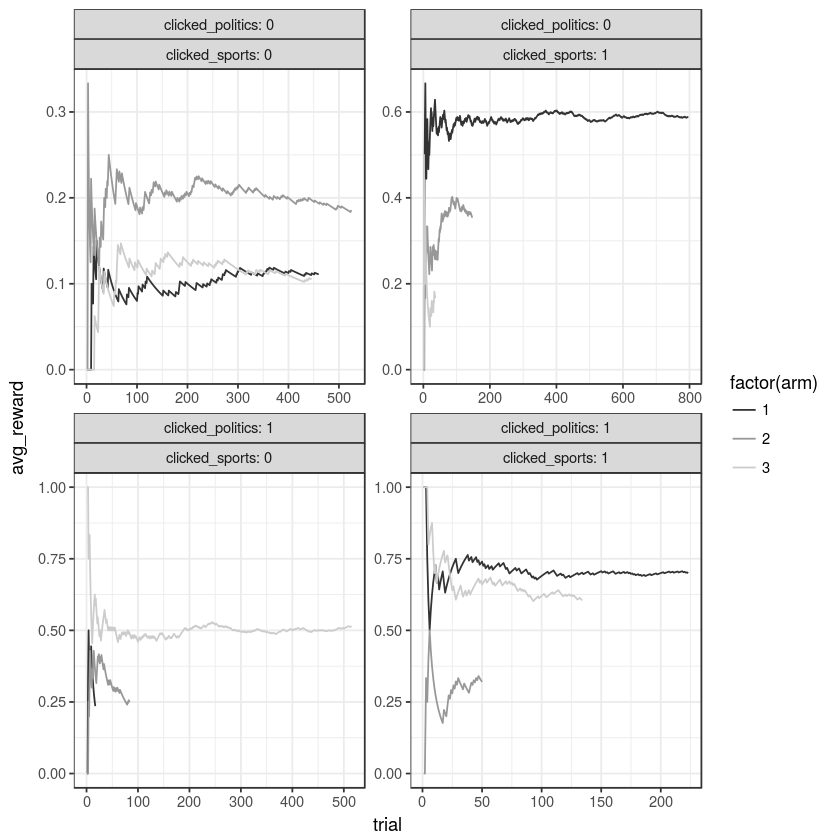

In [10]:
bandit_data xœ
  filter(arm_choice < 10) %>%
  group_by(clicked_sports, clicked_politics, arm_choice) %>%
  mutate(total_reward = cumsum(click), trial = c(1:n())) %>%
  mutate(avg_reward = total_reward/trial) %>%
  ggplot(aes(x = trial, y = avg_reward, color = factor(arm), group = factor(arm))) +
  geom_path() +
  facet_wrap(~clicked_politics + clicked_sports, scales = "free", labeller = "label_both") +
  theme_bw() +
  scale_colour_grey()